In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import skew

%config InlineBackend.figure_format = 'png' #set 'png' here when working on notebook
%matplotlib inline

train = pd.read_csv("../data/train.csv")
test = pd.read_csv("../data/test.csv")

In [2]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
all_data = pd.concat((train.loc[:, 'MSSubClass':'SaleCondition'],
                     test.loc[:, 'MSSubClass':'SaleCondition']))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10dcc4d30>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1046036a0>]], dtype=object)

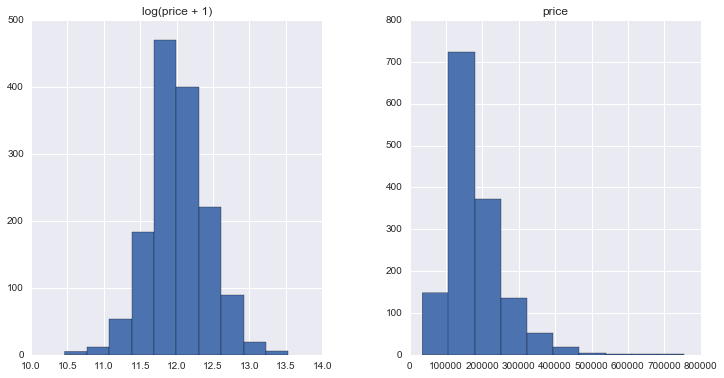

In [4]:
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
prices = pd.DataFrame({"price":train["SalePrice"], "log(price + 1)":np.log1p(train["SalePrice"])})
prices.hist()

In [5]:
#log transform the target:
train["SalePrice"] = np.log1p(train["SalePrice"])

#log transform skewed numeric features:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

skewed_feats = train.loc[:,numeric_feats.get_values()].apply(lambda x: skew(x.dropna()))
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

In [6]:
all_data = pd.get_dummies(all_data)

In [7]:
#filling NA's with the mean of the column:
all_data = all_data.fillna(all_data[:train.shape[0]].mean())

all_data.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,4.110874,4.189655,9.042040,7,5,2003,2003,5.283204,6.561031,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,3.044522,4.394449,9.169623,6,8,1976,1976,0.000000,6.886532,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,4.110874,4.234107,9.328212,7,5,2001,2002,5.093750,6.188264,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,4.262680,4.110874,9.164401,7,5,1915,1970,0.000000,5.379897,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
4,4.110874,4.442651,9.565284,8,5,2000,2000,5.860786,6.486161,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [8]:
#creating matrices for sklearn:
X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]
y = train.SalePrice

### Models


In [9]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.cross_validation import cross_val_score

def rmse_cv(model):
    rmse = np.sqrt(-cross_val_score(model, X_train, y, scoring="mean_squared_error", cv = 5))
    return(rmse)

In [10]:
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge = [rmse_cv(Ridge(alpha= alpha)).mean()
           for alpha in alphas]

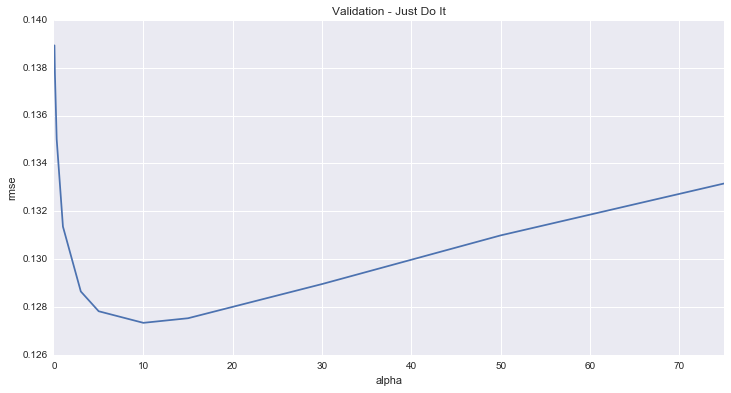

In [11]:
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Validation - Just Do It")
plt.xlabel("alpha")
plt.ylabel("rmse")

In [12]:
cv_ridge.min()

0.12733664928777028

In [13]:
model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005]).fit(X_train, y)

rmse_cv(model_lasso).mean()

0.12314592817531496

In [14]:
coef = pd.Series(model_lasso.coef_, index = X_train.columns)

In [15]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 110 variables and eliminated the other 178 variables


In [16]:
imp_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])

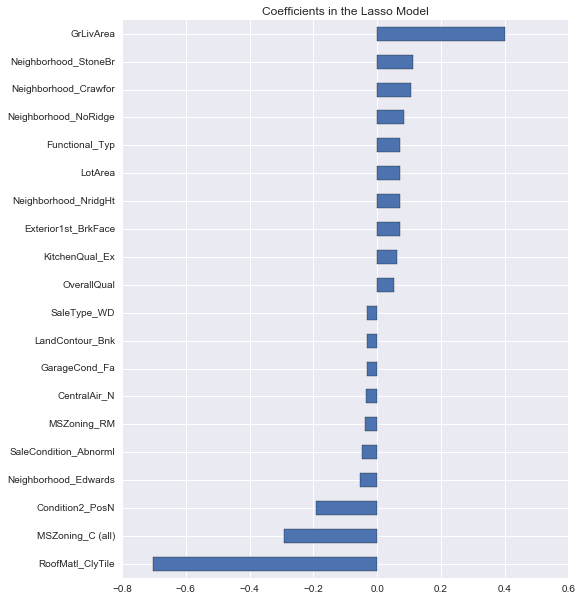

In [17]:
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

In [18]:
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)

preds = pd.DataFrame({"preds":model_lasso.predict(X_train), "true":y})
preds["residuals"] = preds["true"] - preds["preds"]

In [19]:
preds = np.expm1(model_lasso.predict(X_test))

In [20]:
solution = pd.DataFrame({"id":test.Id, "SalePrice":preds})
solution.to_csv("ridge_sol.csv", index = False)